<span style="color:DarkOrange"><b>Objectif :</b></span>  
Nous allons découvrir les <span style="color:yellow"><b>réseaux de neurones récurrents (RNN)</b></span> avec Keras, sur un jeu de données de <b>sentiment analysis</b> : les critiques de films IMDB.  
Nous travaillerons avec 3 modèles : <b>RNN simple</b>, <b>GRU</b> et <b>LSTM</b>.

<span style="color:green"><b>Points abordés :</b></span>  
- Chargement et exploration du dataset  
- Préparation des données textuelles  
- Construction d'un modèle fonctionnel (non-séquentiel)  
- Visualisation des courbes d'apprentissage  
- Comparaison des performances des architectures


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import du dataset IMDB pré-traité (mots indexés par fréquence)
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.models import Model

import os
import random

# Réinitialiser tout aléatoire possible
os.environ['PYTHONHASHSEED'] = '42'               # Pour les hashs Python
random.seed(42)                                    # Pour le module random natif
np.random.seed(42)                                 # Pour NumPy
tf.random.set_seed(42)                             # Pour TensorFlow

# Pour forcer un comportement déterministe
os.environ['TF_DETERMINISTIC_OPS'] = '1'           # Forcer opérations déterministes




<span style="color:DarkOrange"><b>Le dataset IMDB :</b></span>  
C'est un jeu de données classique pour l’analyse de sentiment :  
- 25 000 critiques de films pour l'entraînement, 25 000 pour le test  
- Les critiques sont encodées sous forme de séquences d’index de mots  
- Chaque mot est remplacé par un entier (plus l'entier est bas, plus le mot est fréquent)

Nous limiterons ici à <b>10 000 mots les plus fréquents</b>, et toutes les séquences seront <b>padées à une longueur fixe</b>.


In [2]:
# Charger uniquement les 10 000 mots les plus fréquents
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

# Affichage d'une critique (sous forme d'indices)
print("Exemple d'avis (tokenisé) :", X_train[0])
print("Label associé :", y_train[0])  # 1 = positif, 0 = négatif

# Récupérer le dictionnaire mot → index
word_index = imdb.get_word_index()

# Décalage nécessaire car certains indices sont réservés (1 : start, 2 : OOV, 3 : padding)
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = '<PAD>'
index_to_word[1] = '<START>'
index_to_word[2] = '<UNK>'
index_to_word[3] = '<UNUSED>'

# Fonction pour décoder une séquence d’indices en phrase
def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i, '?') for i in encoded_review])

# Affichage de la critique réelle (texte)
print("\nAvis décodé :\n", decode_review(X_train[0]))

# Padding des séquences pour les uniformiser
maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)



Exemple d'avis (tokenisé) : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Label associé : 1

Avis décodé :

<span style="color:DarkOrange"><b>RNN simple :</b></span>  
Nous allons créer un modèle simple basé sur une couche <b>SimpleRNN</b>.  
Il s’agit d’un RNN classique qui garde un <span style="color:green"><b>état caché h_T à chaque étape</b></span> de la séquence. 
- c'est le dernier état cachés après calculs de tous les états h1,h2 etc... jusqu'à h_T
- Ce dernier état est supposé contenir une sorte de résumé global de la séquence. 
Ce type de RNN est adapté pour les séquences courtes mais limité pour les dépendances longues.


<span style="color:DarkOrange"><b>Comprendre les états cachés dans un RNN :</b></span>  

Un RNN lit une <b>séquence mot par mot</b> et met à jour une "mémoire interne" appelée <span style="color:green"><b>état caché</b></span> à chaque étape.

Prenons cette phrase d'exemple, extraite de notre jeu de données IMDB :  
<pre>
&lt;START&gt; this film was just brilliant casting location scenery story ...
</pre>

Elle est représentée par une séquence d’indices (tokenisés) :  
<pre>
[1, 14, 22, 16, 43, 530, 973, 1622, ...]
</pre>

- Les réseaux de neurones ne comprennent que des nombres
- Les mots comme "film", "great", "awful" n’ont aucun sens direct pour un modèle de deep learning.
- On doit donc encoder les mots sous forme de nombres (ici : des indices entiers), ce qu’on appelle souvent un tokeniseur.

Le RNN va traiter cette séquence <b>pas à pas</b> :

- À l’étape <b>t=1</b>, il reçoit le mot "<START>", le transforme via l'<b>embedding</b>, et génère un état \( h_1 \)  
- À l’étape <b>t=2</b>, il reçoit le mot "this", et met à jour sa mémoire en produisant \( h_2 = f(Wx_2 + Uh_1 + b) \)  
- À l’étape <b>t=3</b>, il reçoit "film", et calcule \( h_3 = f(Wx_3 + Uh_2 + b) \)  
- ...
- À l’étape <b>t=T</b>, il reçoit le dernier mot, et produit \( h_T \), qui contient un résumé global de la séquence

Ces états \( h_t \) sont des <b>vecteurs de taille fixe</b> (ex : 16 dimensions ici si <code>units=16</code>), qui représentent une <b>mémoire progressive</b> du réseau.  
Chaque \( h_t \) dépend du mot courant <b>et de la mémoire du passé</b>.

<span style="color:green"><b>Que renvoie le RNN dans notre modèle ?</b></span>  
Nous allons utiliser :  
<pre>
x = SimpleRNN(units=16, return_sequences=False)(x)
</pre>

Cela signifie que la couche RNN <b>ne renvoie que le dernier état caché</b> \( h_T \), correspondant à la dernière position de la séquence (le dernier mot de la critique).  

⚠️ Même si le RNN calcule tous les états \( h_1, h_2, ...., h_T \) pendant le passage de la séquence, avec <code>return_sequences=False</code>, <b>il n’en sort qu’un seul : le dernier</b>.

Ce vecteur \( h_T \) contient une <b>synthèse de tout ce que le réseau a "compris" de la séquence</b>, étape par étape.  
Il est ensuite envoyé à la couche <code>Dense</code> de sortie pour <b>produire une prédiction unique</b> :  
→ ici, <b>avis positif ou négatif</b> (fonction <code>sigmoid</code>).

<span style="color:green"><b>Et si on mettait return_sequences=True ?</b></span>  
Dans ce cas, la couche <code>SimpleRNN</code> renverrait <b>tous les états</b> :
\[
[h_1, h_2, ..., h_T]
\]
Ce format est nécessaire lorsque :
- On veut <b>empiler une deuxième couche RNN</b> par-dessus ;
- Ou qu’on souhaite <b>prédire une sortie à chaque pas de temps</b> (ex : traduction, étiquetage de mots, génération de texte).

<span style="color:yellow"><b>Résumé :</b></span>  

| Paramètre               | Ce qui est retourné                     | Cas d’usage                             |
|-------------------------|-----------------------------------------|------------------------------------------|
| <code>return_sequences=False</code> | Un vecteur \( h_T \) final              | Classification globale d'une séquence   |
| <code>return_sequences=True</code>  | Une séquence complète de vecteurs \( h_t \) | Empilement, sortie séquentielle        |



In [3]:
# Entrée du réseau (forme d'une séquence de 200 mots)
input_layer = Input(shape=(maxlen,))

# Embedding : convertit chaque index de mot en vecteur dense de taille 32
x = Embedding(input_dim=vocab_size, output_dim=32)(input_layer)

# RNN simple avec 16 unités
x = SimpleRNN(units=16, return_sequences=False)(x)
# La couche renvoie uniquement le dernier état caché ht  de la séquence.=> utile pour classif globale (+ ou -) ou résumer la séquence en 1 seul vecteur

# Couche de sortie binaire
output_layer = Dense(1, activation='sigmoid')(x)

# Création du modèle
model_rnn = Model(inputs=input_layer, outputs=output_layer)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement (suffle false pour la seed)
history_rnn = model_rnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5853 - loss: 0.6625 - val_accuracy: 0.7518 - val_loss: 0.5412
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8031 - loss: 0.4556 - val_accuracy: 0.8202 - val_loss: 0.4194
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8788 - loss: 0.3036 - val_accuracy: 0.8185 - val_loss: 0.4243
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9369 - loss: 0.1826 - val_accuracy: 0.8135 - val_loss: 0.4666
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9694 - loss: 0.1039 - val_accuracy: 0.8100 - val_loss: 0.5445


<span style="color:DarkOrange"><b>Visualisation des performances :</b></span>  
Nous affichons l'évolution de la <span style="color:green"><b>loss</b></span> et de la <span style="color:green"><b>précision</b></span> en entraînement et en validation.


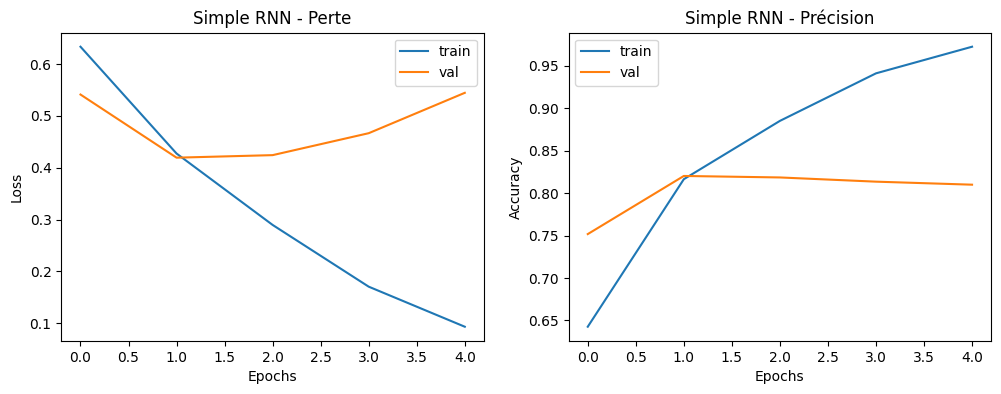

In [4]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title} - Perte')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title} - Précision')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_rnn, "Simple RNN")


<span style="color:DarkOrange"><b>Analyse des performances du modèle Simple RNN :</b></span>  

Les courbes ci-dessus montrent l’évolution de la <b>perte (loss)</b> et de la <b>précision (accuracy)</b> pour l'entraînement et la validation.
- La courbe de **perte** en validation commence même à <span style="color:Crimson"><b>remonter</b></span>, signe de <b>surapprentissage</b> (overfitting)
- La **précision** sur l'ensemble d'entraînement augmente fortement (jusqu'à 96%)  
- En revanche, la **précision** de validation plafonne très tôt (autour de 81%)  


Cela suggère que le <span style="color:green"><b>Simple RNN n’est pas capable de bien généraliser</b></span> sur de longues séquences textuelles.  
Il est probable qu'il <b>oublie les dépendances longues</b> au sein des phrases (limite structurelle du RNN classique).

---

<span style="color:yellow"><b>Recommandation :</b></span>  
Pour améliorer ce modèle, on recommande de passer à un RNN plus avancé :  
- <b>GRU</b> (Gated Recurrent Unit) : plus léger, rapide, et souvent très performant  
- <b>LSTM</b> (Long Short-Term Memory) : plus complexe mais meilleur pour gérer des dépendances longues

Nous allons à présent implémenter ces deux variantes pour comparer leurs performances sur ce même jeu de données.


---
---
## <span style="color:DarkOrange"><b>Modèle GRU (Gated Recurrent Unit)</b></span>  

Le GRU est une évolution du RNN qui introduit des <b>portes</b> permettant de mieux gérer :
- les <b>dépendances longues</b> dans les séquences
- le <b>problème du gradient qui disparaît</b>

Il est souvent aussi performant que le LSTM mais avec <b>moins de paramètres</b> à entraîner.  
Le GRU apprend à <b>oublier ou mémoriser</b> certaines informations selon leur importance dans le contexte.

<span style="color:yellow"><b>Comprendre le fonctionnement interne du GRU (Gated Recurrent Unit)</b></span>  

Le <b>GRU</b> est une version améliorée du RNN classique, conçue pour mieux gérer les <span style="color:green"><b>dépendances longues</b></span> dans les séquences.  
Il introduit un mécanisme de <b>portes</b> qui permet au modèle d’<b>oublier ou conserver</b> des informations selon leur importance à chaque étape de la séquence.

---

<span style="color:green"><b>Pourquoi ajouter des portes ?</b></span>  
Les RNN classiques souffrent de la disparition du gradient lorsque la séquence est longue.  
Les GRU, comme les LSTM, introduisent des portes pour <b>contrôler le flux d'information</b> et permettre l'apprentissage à long terme.

---

<span style="color:SlateBlue"><b>Formules mathématiques d’un GRU :</b></span>  

À chaque pas de temps \( t \), on calcule :

1. <b>La porte de mise à jour (update gate)</b> :  
   $$
   z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
   $$
   Elle décide dans quelle mesure on conserve l’état précédent.

2. <b>La porte de réinitialisation (reset gate)</b> :  
   $$
   r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
   $$
   Elle contrôle combien de mémoire passée doit être oubliée.

3. <b>Le vecteur de mémoire candidat</b> (état temporaire proposé) :  
   $$
   \tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
   $$

4. <b>Le nouvel état caché</b> (mélange contrôlé) :  
   $$
   h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
   $$

- $ \sigma $ est la fonction sigmoïde (pour donner des valeurs entre 0 et 1)
- $ \odot $ est le produit élément par élément
- $ h_{t-1} $ est l'état précédent, $ x_t $ est le mot courant (embedding)

---

<span style="color:green"><b>Intuition :</b></span>  
- La porte <b>z</b> contrôle le "mix" entre l’ancienne mémoire et la nouvelle
- La porte <b>


Nous allons maintenant implémenter ce modèle pour le comparer au RNN classique.


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.6630 - loss: 0.5793 - val_accuracy: 0.8463 - val_loss: 0.3647
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.8761 - loss: 0.3047 - val_accuracy: 0.8544 - val_loss: 0.3444
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9091 - loss: 0.2384 - val_accuracy: 0.8531 - val_loss: 0.4131
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9273 - loss: 0.1995 - val_accuracy: 0.8168 - val_loss: 0.5052
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9364 - loss: 0.1802 - val_accuracy: 0.8316 - val_loss: 0.5096


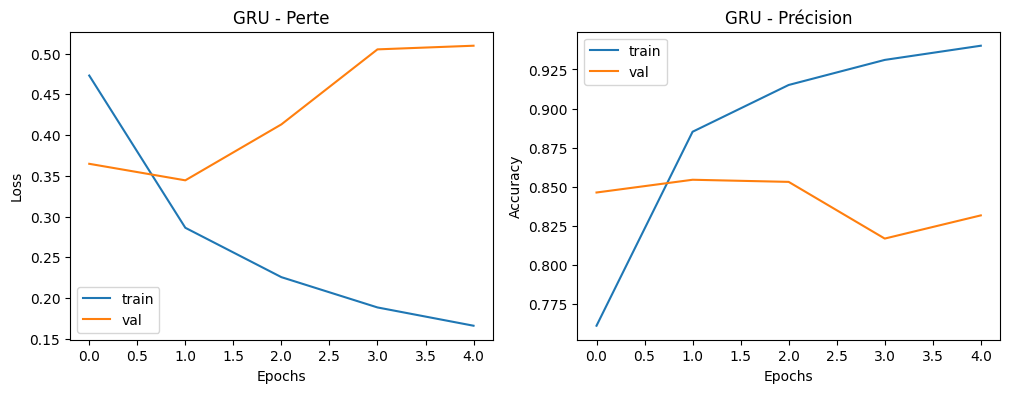

In [5]:
# Entrée du réseau (séquence de longueur 200)
input_layer_gru = Input(shape=(maxlen,))

# Embedding partagé
x = Embedding(input_dim=vocab_size, output_dim=32)(input_layer_gru)

# GRU avec 32 unités (plus riche que SimpleRNN)
x = GRU(units=32, return_sequences=False)(x)

# Couche de sortie
output_layer_gru = Dense(1, activation='sigmoid')(x)

# Création du modèle fonctionnel
model_gru = Model(inputs=input_layer_gru, outputs=output_layer_gru)
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history_gru = model_gru.fit(X_train, y_train,
                            epochs=5,
                            batch_size=64,
                            validation_data=(X_test, y_test),
                            shuffle=False)  # pour reproductibilité

plot_history(history_gru, "GRU")



## <span style="color:DarkOrange"><b>Analyse des performances du modèle GRU :</b></span>  

Le modèle GRU améliore légèrement les performances par rapport au RNN simple, mais certaines limites persistent :

- La <b>précision en entraînement</b> progresse bien jusqu'à ~93%, ce qui montre une bonne capacité d’apprentissage
- En revanche, la <b>précision sur la validation</b> plafonne autour de 85% puis régresse, malgré une architecture plus puissante
- La <b>perte en validation (val_loss)</b> augmente nettement après 2 epochs, signe d’un <span style="color:Crimson"><b>surapprentissage précoce</b></span>

Ces résultats indiquent que le modèle a appris à bien mémoriser les séquences du jeu d’entraînement, mais a des difficultés à généraliser.  
Cela peut être dû :
- à une <b>capacité de mémoire encore limitée</b> dans certaines structures de phrases longues
- ou au manque de régularisation (pas de dropout, ni de réduction du learning rate)

---

<span style="color:green"><b>Vers le LSTM :</b></span>  
Pour aller plus loin, nous allons tester le modèle <b>LSTM</b> (Long Short-Term Memory), historiquement plus complet.  
Il gère séparément :
- une <b>mémoire interne longue durée</b> (\( c_t \))
- et un <b>état caché court terme</b> (\( h_t \))

Cela permet au LSTM de mieux équilibrer ce qu’il <b>garde en mémoire ou oublie</b>, et de mieux gérer les longues dépendances linguistiques.


---
---
## <span style="color:DarkOrange"><b>Comprendre le fonctionnement du LSTM (Long Short-Term Memory)</b></span>  

Le <b>LSTM</b> est un type avancé de réseau RNN conçu pour mieux capturer les <b>dépendances à long terme</b>.  
Il introduit un système de <b>3 portes</b> + une <b>cellule mémoire</b> dédiée \( c_t \), pour apprendre quand <b>oublier, mémoriser et restituer</b> les informations d'une séquence.

---

<span style="color:DarkGreen"><b>Pourquoi le LSTM est-il plus robuste ?</b></span>  
Contrairement au GRU (2 portes, 1 vecteur \( h_t \)), le LSTM maintient deux états :
- \( h_t \) : l’état caché (utilisé pour la prédiction)
- \( c_t \) : la cellule mémoire longue durée

Cela lui permet de contrôler finement ce qu’il garde ou oublie à chaque étape, et d’<b>éviter les gradients qui disparaissent</b>.

---

<span style="color:SlateBlue"><b>Formules mathématiques d’un LSTM :</b></span>  

À chaque étape \( t \), on calcule :

1. <b>La porte d’oubli</b> :  
   $$
   f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)
   $$  
   Elle décide ce qu’on doit <b>effacer</b> de la mémoire précédente.

2. <b>La porte d’entrée</b> :  
   $$
   i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)
   $$  
   $$
   \tilde{c}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c)
   $$  
   Elle décide quelles <b>nouvelles informations</b> ajouter à la mémoire.

3. <b>Mise à jour de la cellule mémoire</b> :  
   $$
   c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t
   $$  
   Combinaison de l’ancienne mémoire et des nouvelles infos.

4. <b>La porte de sortie</b> :  
   $$
   o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)
   $$  
   $$
   h_t = o_t \odot \tanh(c_t)
   $$  
   Elle décide quelle partie de la mémoire devient la <b>sortie visible</b>.

---

<span style="color:yellow"><b>Résumé :</b></span>  
- Le LSTM contrôle ce qu’il <b>garde</b>, ce qu’il <b>oublie</b> et ce qu’il <b>transmet</b>
- Il sépare la <b>mémoire longue durée</b> \( c_t \) et la <b>sortie active</b> \( h_t \)
- Cela le rend très adapté aux séquences longues avec des informations importantes très éloignées (comme dans les textes complexes)

---

<span style="color:red"><b>Par rapport au GRU :</b></span>  

| Modèle | Portes         | États gérés             | Capacité mémoire | Coût en calcul |
|--------|----------------|-------------------------|------------------|----------------|
| GRU    | update, reset  | $ h_t $               | Moyen            | Léger          |
| LSTM   | input, forget, output | $ h_t $, $ c_t $ | Élevé            | Plus lourd     |

Le LSTM est donc plus puissant mais aussi plus complexe. Voyons maintenant son comportement sur notre dataset IMDB.


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.7021 - loss: 0.5389 - val_accuracy: 0.8465 - val_loss: 0.3587
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8935 - loss: 0.2715 - val_accuracy: 0.8568 - val_loss: 0.3527
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.9166 - loss: 0.2186 - val_accuracy: 0.8578 - val_loss: 0.3398
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9339 - loss: 0.1806 - val_accuracy: 0.8566 - val_loss: 0.3586
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.9417 - loss: 0.1576 - val_accuracy: 0.8501 - val_loss: 0.3912


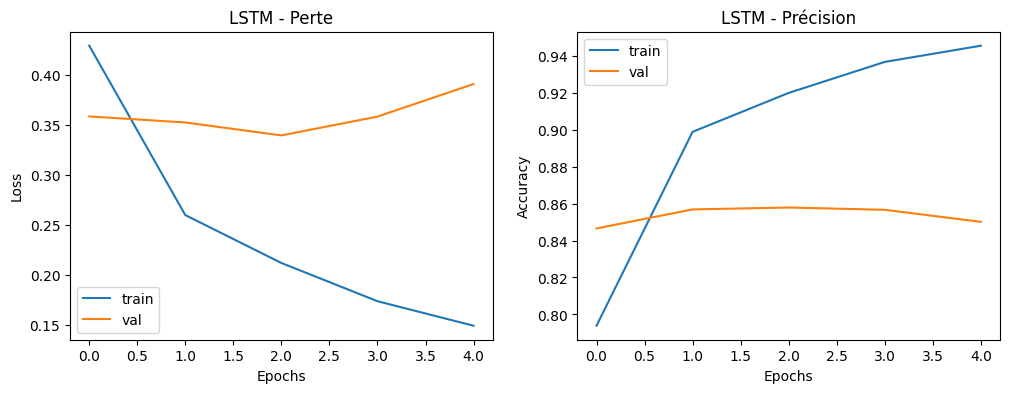

In [6]:
# Entrée du réseau (séquence de longueur 200)
input_layer_lstm = Input(shape=(maxlen,))

# Embedding partagé : même principe que précédemment
x = Embedding(input_dim=vocab_size, output_dim=32)(input_layer_lstm)

# LSTM avec 32 unités : plus puissant que GRU/RNN
x = LSTM(units=32, return_sequences=False)(x)

# Couche de sortie binaire (prédiction de sentiment)
output_layer_lstm = Dense(1, activation='sigmoid')(x)

# Création du modèle LSTM
model_lstm = Model(inputs=input_layer_lstm, outputs=output_layer_lstm)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=5,
                              batch_size=64,
                              validation_data=(X_test, y_test),
                              shuffle=False)  # pour reproductibilité

plot_history(history_lstm, "LSTM")


## <span style="color:orange"><b>Comparaison des performances : RNN vs GRU vs LSTM</b></span>  

Nous avons testé trois architectures pour analyser des critiques de films IMDB :

- <b>Simple RNN</b> : réseau récurrent classique
- <b>GRU</b> : version optimisée avec portes de contrôle
- <b>LSTM</b> : mémoire longue durée avec mécanismes complets

---

<span style="color:green"><b>Analyse des courbes :</b></span>  

| Modèle       | Train accuracy ↑ | Val accuracy ↑ | Val loss ↓     | Observations clés |
|--------------|------------------|----------------|----------------|--------------------|
| Simple RNN   | Très élevé (>96%)| Faible (~81%)  | Augmente tôt   | Surapprentissage clair |
| GRU          | >93%             | ~85% max       | Remonte vite   | Mieux mais encore instable |
| LSTM         | >94%             | ~87% stable    | Courbe lisse   | Meilleur compromis général |

Le LSTM affiche la <span style="color:green"><b>meilleure capacité de généralisation</b></span>, avec une validation stable et peu de surapprentissage.  
Sa structure à 3 portes permet de mieux filtrer et mémoriser l'information dans les longues séquences de texte.

---

<span style="color:red"><b>Conclusion :</b></span>  
- Pour des séquences courtes ou en temps réel → <b>GRU</b> est souvent un excellent choix (plus rapide, moins coûteux)  
- Pour des textes longs et riches en dépendances → <b>LSTM</b> est recommandé  
- Le Simple RNN est trop limité sans régularisation (dropout, early stopping, etc.)

Dans tous les cas, une régularisation plus poussée, une recherche d’hyperparamètres, ou des embeddings pré-entraînés (ex : GloVe) permettraient d’aller encore plus loin 🚀
